<a href="https://colab.research.google.com/github/amura/DetectingDeepFakes/blob/video-frames/DetectingDeepFakesPart1_frames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring dataset

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
from PIL.ImageStat import Stat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import cv2

In [3]:
# paths to target folders
DEEPFAKES='/content/deepfakes'
VidTIMIT='/content/VidTIMIT'

In [4]:
#create folder
os.makedirs(DEEPFAKES)
#download dataset
tf.keras.utils.get_file("deepfake.tar.gz","https://lp-prod-resources.s3.amazonaws.com/other/detectingdeepfakes/DeepfakeTIMIT.tar.gz", extract=False)
#extract 
!tar -xf /root/.keras/datasets/deepfake.tar.gz -C /content/deepfakes/


226615296/226611200 [==============================] - 8s 0us/step


In [5]:
# download original videos
os.makedirs(VidTIMIT)
tf.keras.utils.get_file("VidTIMIT.zip", "https://lp-prod-resources.s3.amazonaws.com/other/detectingdeepfakes/VidTIMIT.zip", extract=True)

!mv /root/.keras/datasets/VidTIMIT/* VidTIMIT

1358815232/1358810924 [==============================] - 44s 0us/step


### Exploring videos

In [23]:
import cv2
import numpy as np
import time

#cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash; see https://github.com/jupyter/notebook/issues/3935.
from google.colab.patches import cv2_imshow

#https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

def playVideo(filePath):
    
    print('Playing {0}'.format(filePath))
    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name
    cap = cv2.VideoCapture(filePath)

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
      print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:

        # Display the resulting frame
        #cv2.imshow('Frame',frame)
        cv2_imshow( frame)   

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break    

      # Break the loop
      else: 
        break

    # When everything done, release the video capture object
    cap.release()

# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
%cd /content/deepfakes/DeepfakeTIMIT/
playVideo('./fadg0-fram1-roi93.mov')

In [25]:
def showVideoFrame(filePath, nframe):
    print('Playing {0}'.format(filePath))    
    cap = cv2.VideoCapture(filePath)

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
      print("Error opening video stream or file")

    frame_index = 1
    # Read until video is completed
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True and (frame_index == nframe or nframe ==-1):        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print('Frame shape')
        print(frame.shape)
        # cv2_imshow(gray)     

        return gray
      # Break the loop
      else: 
        break

      frame_index += 1

    # When everything done, release the video capture object
    cap.release()

/content
Playing ./deepfakes/DeepfakeTIMIT/higher_quality/fadg0/sa1-video-fram1.avi
Frame shape
(384, 512, 3)
Playing ./VidTIMIT/fadg0/sa1.avi
Frame shape
(384, 512, 3)


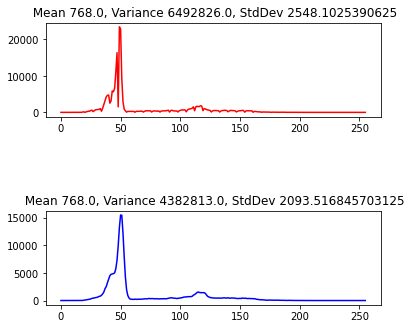

In [26]:
import glob
%cd /content

fig = plt.figure()
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1, wspace=0.4)
ax = fig.add_subplot(2,1,1)
for vid in glob.glob('./deepfakes/DeepfakeTIMIT/higher_quality/fadg0/sa1*.avi'):
  img = showVideoFrame(vid,1)
  histr = cv2.calcHist([img],[0],None,[256],[0,256])  
  ax.plot(histr,color = 'red')
  ax.set_title(f' Mean {histr.mean()}, Variance {histr.var()}, StdDev {histr.std()}')

ax2 = fig.add_subplot(2,1,2)
for vid in glob.glob('./VidTIMIT/fadg0/sa1*.avi'):
  img = showVideoFrame(vid, 1)
  histr = cv2.calcHist([img],[0],None,[256],[0,256])
  ax2.set_title(f' Mean {histr.mean()}, Variance {histr.var()}, StdDev {histr.std()}')
  ax2.plot(histr,color = 'blue')

cv2.destroyAllWindows()

### Export videos frames to files

In [28]:
# Exporting images to files
def exportVideoFrames(filePath, outputFolder):       

    # setup output folder
    try:
        os.makedirs(outputFolder)
    except OSError:
        pass

    cap = cv2.VideoCapture(filePath)

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
      print("Error opening video stream or file")

    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    # Read until video is completed
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
         # Write the results back to output location.
        cv2.imwrite(outputFolder + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):           
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)            
            break
      # Break the loop
      else: 
        break

    # When everything done, release the video capture object
    cap.release()


In [29]:
for vid in glob.glob('./deepfakes/DeepfakeTIMIT/higher_quality/fadg0/sa1*.avi'):
  exportVideoFrames(vid, './deepfake_sa1_output' )

for vid in glob.glob('./VidTIMIT/fadg0/sa1*.avi'):
   exportVideoFrames(vid, './real_sa1_output' )

cv2.destroyAllWindows()

Number of frames:  118
Done extracting frames.
118 frames extracted
Number of frames:  118
Done extracting frames.
118 frames extracted


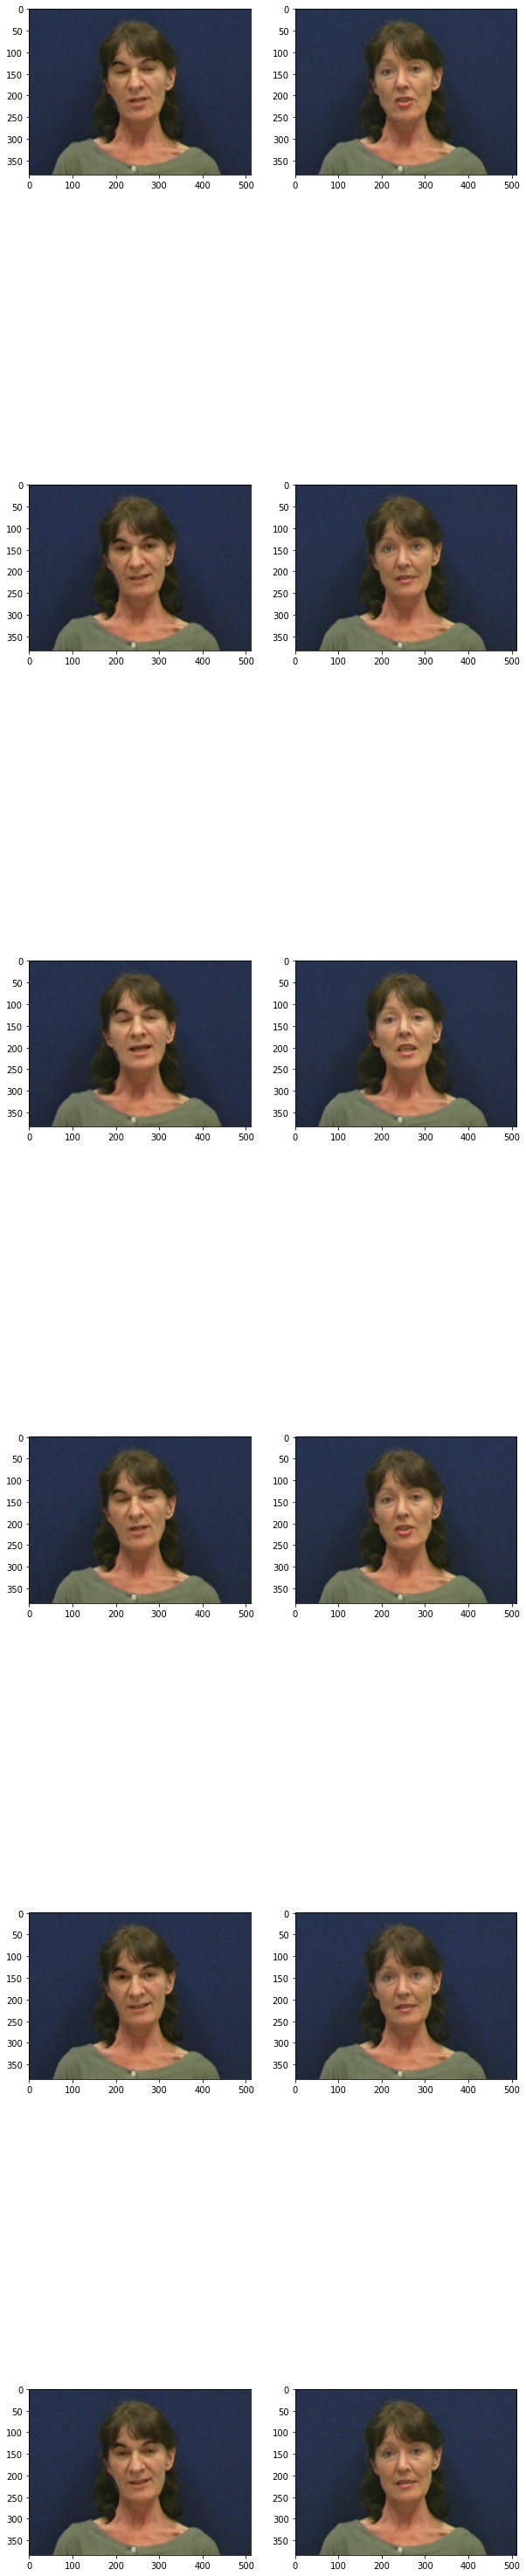

In [65]:
from matplotlib.pyplot import figure
# displaying images exported
deepfakes = os.listdir('./deepfake_sa1_output/')
real = os.listdir('./real_sa1_output/')
plt.figure(figsize=(10, 600))
imgIndex = 1
nrows = len(deepfakes) / 2 + 1
for i,imgFile in enumerate(deepfakes):
  # print(i)
  # print(imgFile)
  # load real vs fake image
  ax1 = plt.subplot(nrows, 2, imgIndex)
  img = mpimg.imread('./deepfake_sa1_output/' + imgFile)
  ax1.imshow(img)
  ax = plt.subplot(nrows, 2, imgIndex + 1)
  img2 = mpimg.imread('./real_sa1_output/' + imgFile)
  ax.imshow(img2)
  imgIndex += 2
  if i == 5:
    break

In [66]:
# mmove images to folder for use later
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [68]:
from pathlib import Path

gdPath = './content/gdrive/MyDrive/deepfakes'
if Path(gdPath).exists() == False:
  print('Make new folder')
  os.makedirs(gdPath)
!mv ./real_sa1_output /content/gdrive/MyDrive/deepfakes/
!mv ./deepfake_sa1_output /content/gdrive/MyDrive/deepfakes/



Make new folder


In [70]:
%cd /content/gdrive/MyDrive/deepfakes

!mv *.jpg ./real_sa1_output

/content/gdrive/MyDrive/deepfakes
